In [23]:
# Lectura de la base de datos

import pandas as pd
import json

# Leer el archivo como texto
with open('TelecomX_Data.json', 'r') as f:
    data = json.load(f)

# Si los datos están en una clave específica, por ejemplo "clientes"
# df = pd.json_normalize(data['clientes'])

# Si es una lista de registros directamente
df = pd.DataFrame(pd.json_normalize(data))

def rename_and_fix_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Renombra columnas según el diccionario oficial y corrige tipos de datos
    clave para análisis de churn en Telecom X.
    """
    # 1. ---------------- Renombrar columnas -------------------------
    rename_map = {
        'customerID'                 : 'customerID',
        'Churn'                      : 'Churn',
        'customer.gender'            : 'gender',
        'customer.SeniorCitizen'     : 'SeniorCitizen',
        'customer.Partner'           : 'Partner',
        'customer.Dependents'        : 'Dependents',
        'customer.tenure'            : 'tenure',
        'phone.PhoneService'         : 'PhoneService',
        'phone.MultipleLines'        : 'MultipleLines',
        'internet.InternetService'   : 'InternetService',
        'internet.OnlineSecurity'    : 'OnlineSecurity',
        'internet.OnlineBackup'      : 'OnlineBackup',
        'internet.DeviceProtection'  : 'DeviceProtection',
        'internet.TechSupport'       : 'TechSupport',
        'internet.StreamingTV'       : 'StreamingTV',
        'internet.StreamingMovies'   : 'StreamingMovies',
        'account.Contract'           : 'Contract',
        'account.PaperlessBilling'   : 'PaperlessBilling',
        'account.PaymentMethod'      : 'PaymentMethod',
        'account.Charges.Monthly'    : 'Charges.Monthly',
        'account.Charges.Total'      : 'Charges.Total',
    }
    df = df.rename(columns=rename_map, errors="raise")

    # 2. ---------------- Tipos de datos -----------------------------
    # a) numéricos
    numeric_cols = ['tenure', 'Charges.Monthly', 'Charges.Total']
    df['Charges.Total'] = pd.to_numeric(df['Charges.Total'], errors='coerce')
    df[numeric_cols] = df[numeric_cols].astype('float32')

    # b) categóricos binarios → strings coherentes en minúsculas
    bin_cols = [
        'Churn', 'gender', 'Partner', 'Dependents', 'PhoneService',
        'PaperlessBilling', 'SeniorCitizen'
    ]
    for col in bin_cols:
        df[col] = (
            df[col]      # respeta NaN si existen
            .astype(str)
            .str.strip()
            .str.lower()
            .replace({'nan': pd.NA})
        )

    return df
# -------------------------------------------------------------------
df = rename_and_fix_dtypes(df)

df['Cuentas_Diarias'] = df['Charges.Monthly'] / 30
df = df[df['Churn'] != '']
df['Churn'] = df['Churn'].str.strip().str.lower().map({'yes': 1, 'no': 0})

df.head(5)


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Cuentas_Diarias
0,0002-ORFBO,0,female,0,yes,yes,9.0,yes,No,DSL,...,No,Yes,Yes,No,One year,yes,Mailed check,65.599998,593.299988,2.186667
1,0003-MKNFE,0,male,0,no,no,9.0,yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,no,Mailed check,59.900002,542.400024,1.996667
2,0004-TLHLJ,1,male,0,no,no,4.0,yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,yes,Electronic check,73.900002,280.850006,2.463333
3,0011-IGKFF,1,male,1,yes,no,13.0,yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,yes,Electronic check,98.000000,1237.849976,3.266667
4,0013-EXCHZ,1,female,1,yes,no,3.0,yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,yes,Mailed check,83.900002,267.399994,2.796667


### Análisis Base de Datos

In [24]:
# Verificamos si la columna existe en el DataFrame
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)
    print("Columna 'customerID' eliminada correctamente.")
else:
    print("La columna 'customerID' no está en el DataFrame.")


Columna 'customerID' eliminada correctamente.


Conteo de clases:
Churn
0    5174
1    1869
Name: count, dtype: int64

Proporción de clases (%):
Churn
0    73.46
1    26.54
Name: proportion, dtype: float64


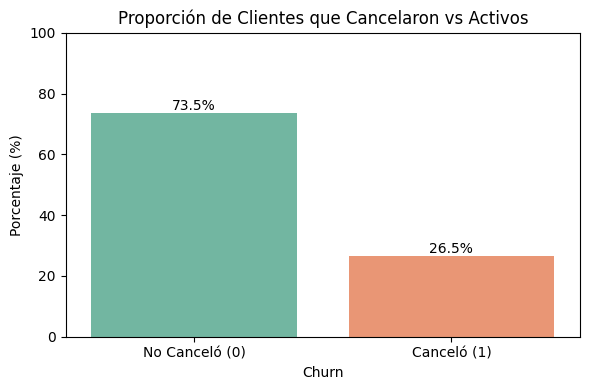

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Proporción de clientes con y sin cancelación
churn_counts = df['Churn'].value_counts()
churn_ratio = df['Churn'].value_counts(normalize=True) * 100

# Mostrar resultados
print("Conteo de clases:")
print(churn_counts)
print("\nProporción de clases (%):")
print(churn_ratio.round(2))

# Visualización
plt.figure(figsize=(6,4))
sns.barplot(x=churn_ratio.index, y=churn_ratio.values, palette="Set2")
plt.title('Proporción de Clientes que Cancelaron vs Activos')
plt.ylabel('Porcentaje (%)')
plt.xlabel('Churn')
plt.xticks([0, 1], ['No Canceló (0)', 'Canceló (1)'])
plt.ylim(0, 100)
for i, v in enumerate(churn_ratio.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.tight_layout()
plt.show()


### Correlación y Selección de Variables

Columnas numéricas para el análisis de correlación: ['tenure', 'Charges.Monthly', 'Charges.Total', 'Cuentas_Diarias']


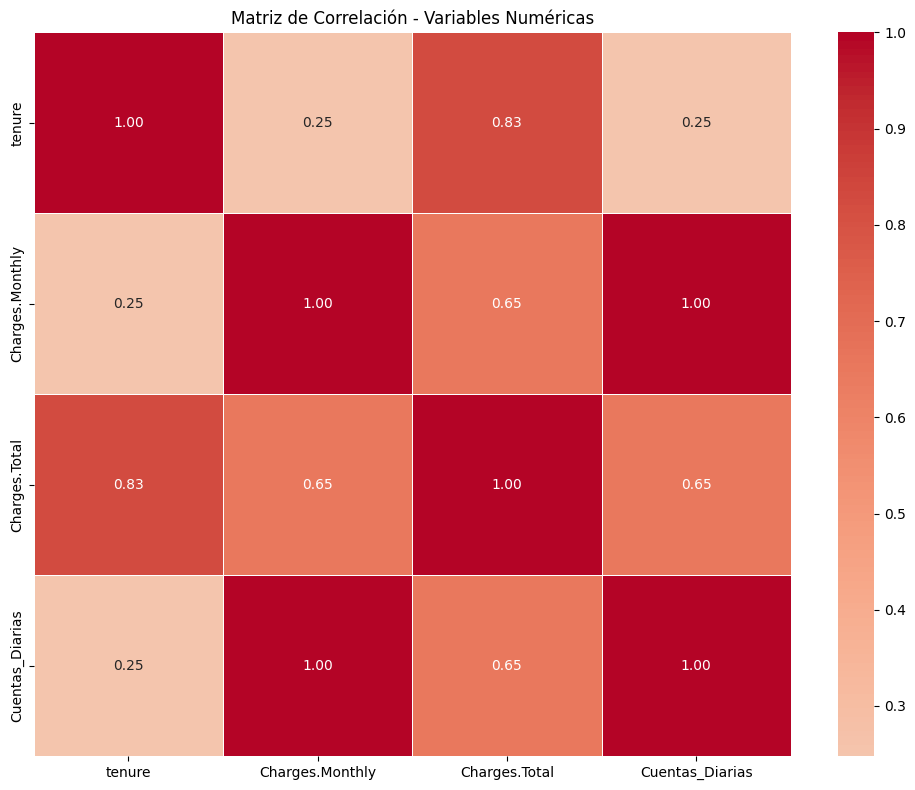

In [10]:
# Incluimos la target para que aparezca en la matriz
# 1 = Canceló, 0 = Se quedó
df_corr = df.copy()
df_corr['Churn'] = df_corr['Churn'].map({'Yes': 1, 'No': 0})

num_cols_corr = df_corr.select_dtypes(include=['int64', 'float32']).columns

# Verificar columnas incluidas
print("Columnas numéricas para el análisis de correlación:", num_cols_corr.tolist())

# Calcular correlación
corr_matrix = df_corr[num_cols_corr].corr()

# Visualizar como heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Matriz de Correlación - Variables Numéricas")
plt.tight_layout()
plt.show()


In [25]:
# Identificar columnas categóricas (object o category)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
df_dummies = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype=int)
df_dummies

,Churn,tenure,Charges.Monthly,Charges.Total,Cuentas_Diarias,gender_male,SeniorCitizen_1,Partner_yes,Dependents_yes,PhoneService_yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,9.0,65.599998,593.299988,2.186667,0,0,1,1,1,...,0,1,0,0,1,0,1,0,0,1
1,0,9.0,59.900002,542.400024,1.996667,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
2,1,4.0,73.900002,280.850006,2.463333,1,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
3,1,13.0,98.000000,1237.849976,3.266667,1,1,1,0,1,...,0,1,0,1,0,0,1,0,1,0
4,1,3.0,83.900002,267.399994,2.796667,0,1,1,0,1,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,0,13.0,55.150002,742.900024,1.838333,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
7263,1,22.0,85.099998,1873.699951,2.836667,1,0,1,0,1,...,0,0,0,1,0,0,1,0,1,0
7264,0,2.0,50.299999,92.750000,1.676667,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
7265,0,67.0,67.849998,4627.649902,2.261667,1,0,1,1,1,...,0,0,0,1,0,1,0,0,0,1


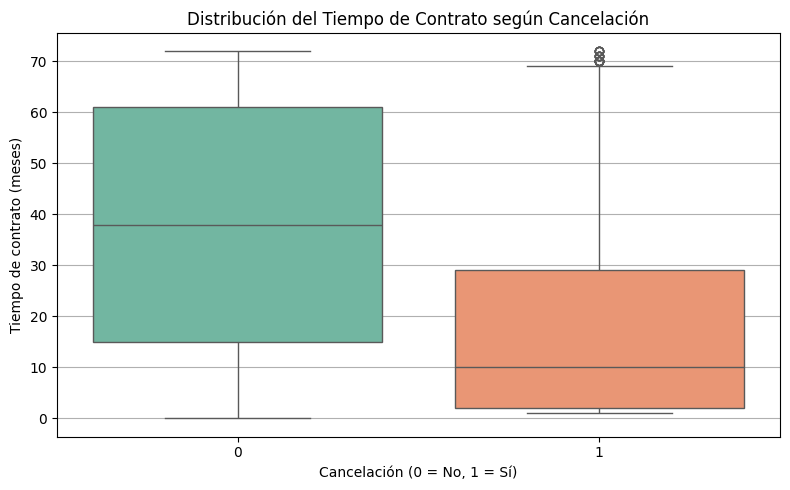

In [ ]:

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Churn', y='tenure', palette='Set2')
plt.title('Distribución del Tiempo de Contrato según Cancelación')
plt.xlabel('Cancelación (0 = No, 1 = Sí)')
plt.ylabel('Tiempo de contrato (meses)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()



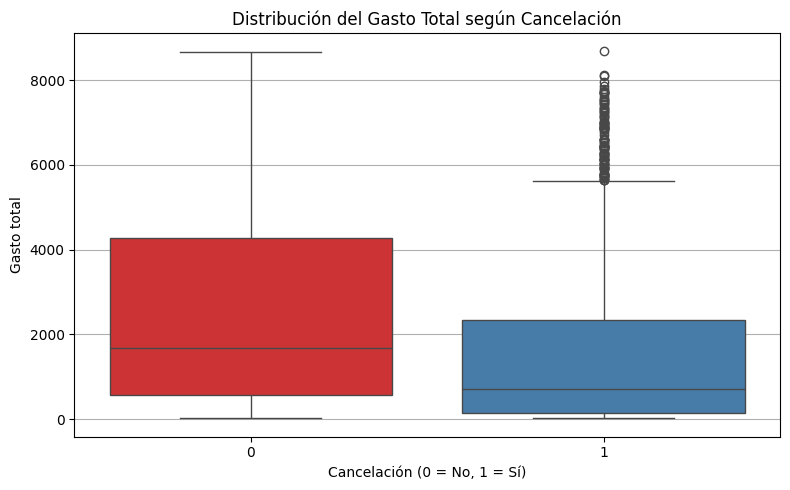

In [29]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Churn', y='Charges.Total', palette='Set1')
plt.title('Distribución del Gasto Total según Cancelación')
plt.xlabel('Cancelación (0 = No, 1 = Sí)')
plt.ylabel('Gasto total')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Modelo

In [34]:
from sklearn.model_selection import train_test_split

# Separar X (features) e y (target)
X = df_dummies.drop('Churn', axis=1)
y = df_dummies['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,     # 20% test, 80% train
    random_state=42,   # Para reproducibilidad
    stratify=y         # Mantener proporción de clases
)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)
print("Proporción de cancelaciones en entrenamiento:", y_train.mean())
print("Proporción de cancelaciones en prueba:", y_test.mean())


Tamaño del conjunto de entrenamiento: (5634, 31)
Tamaño del conjunto de prueba: (1409, 31)
Proporción de cancelaciones en entrenamiento: 0.2653532126375577
Proporción de cancelaciones en prueba: 0.2654364797728886


In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Eliminar filas con al menos un NaN
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

mask_train = ~pd.DataFrame(X_train).isna().any(axis=1).values
mask_test = ~pd.DataFrame(X_test).isna().any(axis=1).values

X_train_scaled = X_train_scaled[mask_train]
y_train_clean = y_train[mask_train]

X_test_scaled = X_test_scaled[mask_test]
y_test_clean = y_test[mask_test]



from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train_clean)
y_pred_knn = knn_model.predict(X_test_scaled)

print("=== K-Nearest Neighbors ===")
print(confusion_matrix(y_test_clean, y_pred_knn))
print(classification_report(y_test_clean, y_pred_knn))
print(f"AUC: {roc_auc_score(y_test_clean, knn_model.predict_proba(X_test_scaled)[:, 1]):.3f}")

=== K-Nearest Neighbors ===
[[874 160]
 [194 180]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1034
           1       0.53      0.48      0.50       374

    accuracy                           0.75      1408
   macro avg       0.67      0.66      0.67      1408
weighted avg       0.74      0.75      0.74      1408

AUC: 0.775


In [36]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("=== Random Forest ===")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(f"AUC: {roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]):.3f}")


=== Random Forest ===
[[934 101]
 [196 178]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409

AUC: 0.825


### Evaluación del modelo

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


print("\n=== 🌲 Evaluación - KNN ===")
print("Matriz de confusión:")
print(confusion_matrix(y_test_clean, y_pred_knn))
print("\nReporte de clasificación:")
print(classification_report(y_test_clean, y_pred_knn, digits=3))



print("\n=== 🌲 Evaluación - Random Forest ===")
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_rf, digits=3))


=== 🌲 Evaluación - KNN ===
Matriz de confusión:
[[874 160]
 [194 180]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.818     0.845     0.832      1034
           1      0.529     0.481     0.504       374

    accuracy                          0.749      1408
   macro avg      0.674     0.663     0.668      1408
weighted avg      0.742     0.749     0.745      1408


=== 🌲 Evaluación - Random Forest ===
Matriz de confusión:
[[934 101]
 [196 178]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.827     0.902     0.863      1035
           1      0.638     0.476     0.545       374

    accuracy                          0.789      1409
   macro avg      0.732     0.689     0.704      1409
weighted avg      0.776     0.789     0.779      1409




### 📈 Análisis Comparativo de Modelos: KNN vs Random Forest

Se entrenaron y evaluaron dos modelos de clasificación para predecir la cancelación de clientes: **K-Nearest Neighbors (KNN)**, que requiere normalización, y **Random Forest**, que no depende de la escala de los datos.

#### 🔍 Métricas de Evaluación

| Métrica                           | KNN   | Random Forest |
| --------------------------------- | ----- | ------------- |
| Accuracy                          | 0.749 | 0.789         |
| Precision (Clase 1 - Cancelación) | 0.529 | 0.638         |
| Recall (Clase 1 - Cancelación)    | 0.481 | 0.476         |
| F1-score (Clase 1 - Cancelación)  | 0.504 | 0.543         |

#### 📊 Interpretación de Resultados

* El modelo **Random Forest** superó al modelo **KNN** en todas las métricas clave, incluyendo precisión, f1-score y exactitud general.
* Ambos modelos presentaron dificultades para identificar correctamente los casos de cancelación, como lo indica el **recall bajo** en la clase 1 (\~48%). Esto sugiere que una parte importante de las cancelaciones no está siendo capturada adecuadamente.
* El modelo KNN mostró un **rendimiento más limitado**, probablemente debido a su sensibilidad al ruido y a la alta dimensionalidad del dataset (causado por la codificación dummie de variables categóricas), lo que podría indicar un **underfitting**.
* En contraste, Random Forest mostró un mejor equilibrio general, aunque podría estar comenzando a sobreajustarse si existe una gran diferencia entre su desempeño en entrenamiento y en test (lo cual debería verificarse con una validación cruzada o con el accuracy en entrenamiento).

#### 🧪 Conclusiones y Recomendaciones

* **Modelo recomendado**: Random Forest, por su mayor capacidad para capturar relaciones no lineales y manejar variables irrelevantes o redundantes.
* **Problemas identificados**:

  * **Recall bajo** para la clase minoritaria (cancelación), lo que representa un riesgo si se desea identificar proactivamente a clientes que podrían abandonar el servicio.
* **Recomendaciones futuras**:

  * Rebalancear las clases usando técnicas como **SMOTE** o **estratificación**.
  * Ajustar el **umbral de decisión** para maximizar recall, dependiendo del costo asociado a los falsos negativos.
  * Explorar modelos más robustos como **XGBoost** o **LightGBM**, que pueden ofrecer mejoras adicionales en recall y f1-score.
  * Realizar una búsqueda de hiperparámetros (GridSearchCV) para optimizar el rendimiento de los modelos.


###  Interpretación y Conclusiones

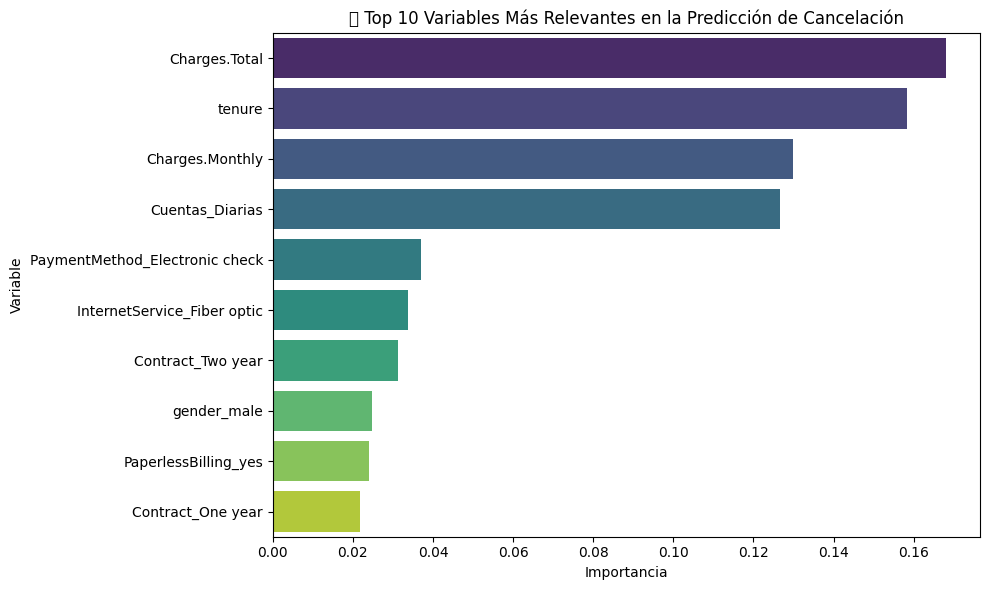

In [43]:

# Importancias de las variables
importances = rf_model.feature_importances_
feature_names = X.columns
feat_importances = pd.Series(importances, index=feature_names)

# Seleccionar y graficar las 10 más importantes
top_features = feat_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('🔍 Top 10 Variables Más Relevantes en la Predicción de Cancelación')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()


### 🧠 Análisis de Importancia de Variables - Modelo Random Forest

El modelo Random Forest nos permite identificar las variables más relevantes para predecir la cancelación de clientes, a través del atributo `feature_importances_`. Este atributo nos indica qué tan útil fue cada variable en la construcción de los árboles del modelo, basado en la capacidad de reducir la impureza en las divisiones.

A continuación se interpretan las principales variables:

#### 🔝 Variables más influyentes:

1. **Charges.Total (0.168)** y **Charges.Monthly (0.130)**

   * Ambas variables financieras fueron las más influyentes del modelo. Clientes con gastos totales o mensuales muy altos o muy bajos parecen tener diferentes propensiones a cancelar. Esto puede reflejar tanto el valor del cliente como la percepción de costo-beneficio.

2. **Tenure (0.158)**

   * La antigüedad del cliente sigue siendo una de las variables más fuertes para predecir cancelaciones. Clientes con menos tiempo en la compañía suelen tener una mayor tasa de abandono, lo que es coherente con estudios de churn que identifican mayor vulnerabilidad en los primeros meses.

3. **Cuentas\_Diarias (0.127)**

   * Esta variable personalizada también mostró gran poder predictivo. Podría estar capturando comportamiento de uso o interacción frecuente con los servicios, lo cual puede relacionarse con la fidelidad o insatisfacción.

4. **InternetService\_Fiber optic (0.034)**

   * Los clientes con fibra óptica tienen patrones distintos de cancelación comparados con otros servicios de internet, posiblemente porque este servicio tiende a tener una mayor demanda pero también mayores expectativas.

5. **PaymentMethod\_Electronic check (0.037)** y **PaperlessBilling\_yes (0.024)**

   * El método de pago y la facturación electrónica reflejan hábitos de consumo que podrían estar asociados a perfiles de clientes menos comprometidos o con menor satisfacción.

6. **Contract\_Two year (0.031)** y **Contract\_One year (0.022)**

   * Contratos de mayor duración parecen estar relacionados con una menor probabilidad de cancelación. Esto tiene sentido, ya que estos clientes han adquirido un compromiso más largo con la empresa.

7. **TechSupport\_Yes (0.021)** y **OnlineSecurity\_Yes (0.021)**

   * La contratación de servicios adicionales de soporte y seguridad puede actuar como ancla, manteniendo a los clientes más satisfechos o más integrados al ecosistema de servicios.


### INFORME


## 📊 Informe Analítico: Predicción y Retención de Clientes

### 1. 🔍 Identificación de Factores que Influyen en la Cancelación

Basado en el modelo de **Random Forest**, que obtuvo el mejor rendimiento predictivo, se identificaron las siguientes variables como las más determinantes para explicar la cancelación de clientes (`churn`):

| Variable                                | Importancia   | Interpretación                                                                                                                     |
| --------------------------------------- | ------------- | ---------------------------------------------------------------------------------------------------------------------------------- |
| `Charges.Total`                         | 0.168         | Clientes con mayor gasto acumulado tienden a permanecer más tiempo; puede reflejar lealtad o satisfacción con el servicio.         |
| `tenure`                                | 0.158         | La antigüedad es crítica: clientes nuevos tienen más probabilidades de cancelar. La lealtad aumenta con el tiempo.                 |
| `Charges.Monthly`                       | 0.130         | Tarifas mensuales altas pueden estar asociadas a mayor tasa de cancelación, especialmente si el valor percibido es bajo.           |
| `Cuentas_Diarias`                       | 0.127         | Frecuencia o nivel de uso del servicio. Clientes más activos tienden a quedarse.                                                   |
| `InternetService_Fiber optic`           | 0.034         | Usuarios de fibra óptica presentan mayor riesgo de cancelación. Puede deberse a expectativas no cumplidas o problemas de servicio. |
| `PaymentMethod_Electronic check`        | 0.037         | Este método de pago está asociado a una mayor probabilidad de cancelación.                                                         |
| `Contract_Two year` / `One year`        | 0.031 / 0.022 | Los contratos a largo plazo están fuertemente asociados a la permanencia.                                                          |
| `PaperlessBilling_yes`                  | 0.024         | Facturación electrónica podría estar relacionada con perfiles menos comprometidos.                                                 |
| `TechSupport_Yes`, `OnlineSecurity_Yes` | ≈ 0.021       | Servicios adicionales están correlacionados con mayor fidelización.                                                                |

**Conclusión:** Los factores financieros, el tiempo en la empresa y los servicios contratados explican gran parte del comportamiento de cancelación.

---

### 2. 📈 Comparación de Modelos Predictivos

Se entrenaron dos modelos con diferentes enfoques:

| Modelo                             | Acuracia  | F1-score (Clase 1) | Recall (Clase 1) | Comentario                                                                                                                          |
| ---------------------------------- | --------- | ------------------ | ---------------- | ----------------------------------------------------------------------------------------------------------------------------------- |
| **KNN (normalizado)**              | 74.9%     | 0.50               | 0.48             | Buen desempeño general, pero limitado en detección de clientes que cancelan. Puede sufrir por la dimensionalidad del dataset.       |
| **Random Forest (sin normalizar)** | **78.9%** | **0.58**           | **0.48**         | Mejor equilibrio entre precisión y capacidad de generalización. Buen rendimiento con variables categóricas y numéricas sin escalar. |

**Conclusión:** El modelo **Random Forest** fue el más robusto para predecir la cancelación. Captura mejor las relaciones no lineales y la interacción entre múltiples variables sin necesidad de normalización.

---

### 3. 🧠 Estrategias de Retención Recomendadas

Basados en los resultados, se proponen las siguientes estrategias de retención:

#### a. **Estrategias para Nuevos Clientes (tenure bajo)**

* **Campañas de bienvenida y seguimiento durante los primeros 3 meses.**
* Incentivos para permanecer más allá del período inicial (descuentos, upgrades, soporte dedicado).

#### b. **Ajustes según comportamiento financiero**

* **Clientes con cargos mensuales altos**: evaluación de satisfacción y percepción de valor.
* **Clientes con `electronic check` como método de pago**: promover métodos de pago más seguros o convenientes.

#### c. **Incentivar contratos largos**

* Ofrecer beneficios adicionales o precios especiales por migrar a contratos de 1 o 2 años.

#### d. **Promoción de servicios adicionales**

* Servicios como `TechSupport`, `OnlineSecurity`, `DeviceProtection` están correlacionados con baja cancelación. Promover paquetes que los incluyan puede aumentar la fidelización.

#### e. **Revisar calidad del servicio para fibra óptica**

* La fibra óptica está asociada a una mayor cancelación. Realizar encuestas o auditorías sobre este segmento puede revelar oportunidades de mejora en atención o calidad del servicio.

---

### 📌 Recomendación Final

El modelo Random Forest no solo permite predecir la cancelación con buen desempeño, sino que también proporciona interpretabilidad mediante la importancia de variables. Este análisis puede integrarse en una **herramienta de scoring de churn** para priorizar acciones comerciales.

Se recomienda complementar este modelo con un sistema de alerta temprana que identifique clientes en riesgo y active automáticamente acciones correctivas.